# Case Study

## Background

Heart disease is the leading cause of death globally. __Heart failure__ is the primary cause of heart diseases, and that refers to a physiological state in which the heart is unable to pump sufficiently to maintain blood flow to meet the body's need. It usually occurs because the heart has become too weak or stiff. 

HF is routinely diagnosed by:
* __Electrocardiogram (ECG)__, which measure heart's rhythm and electrical activity. From the ECG the QRS duration can be computed. An increased QRS duration, indicate dyssynchronous contraction and relaxation of the left and right ventricles and it is a marker of detection of HF subjects.
* __MRI__ or __US imaging__ which provides structural and functional information of the heart. Evaluation of the structure and the function of the ventricles can provide useful information for diagnosis and characterization of disease. 
 	 	
Based on the result of these tests, doctors use NYHA class to classify patients' heart failure according to the severity of their symptoms:

__Class I__: no limitation is experienced in any activities; there are no symptoms from ordinary activities.

__Class II__: slight, mild limitation of activity; the patient is comfortable at rest or with mild exertion.

__Class III__: marked limitation of any activity; the patient is comfortable only at rest.

__Class IV__: any physical activity brings on discomfort and symptoms occur at rest.

### Current diagnostic technique

Currently, the parameters used in clinics to identify cardiac patients are:
* __LVEDV__ which is the maximum amount of blood that heart can pump
* __LVESV__ which is the minium amount of blood that heart can pump
* __LVSV__ which is the amount of blood pumped by the left ventricle of the heart in one contraction. 
* __Ejection fraction (LVEF)__, which computes the amount of blood of the left ventricle (LV) pumps out with each contraction. A normal heart’s ejection fraction may be between 50 and 70 percent.


## Objective

The objective of this workshop is twofold:

1. Improve the quality of a pre-trained segmentation neural network to segment the left ventricle (LV) of the heart
2. Train a simple deep neural network (DNN) to classify between healthy and heart failure subjects using clinical metrics, i.e. LVEDV, LVESV, LVSV and LVEF


# 1. Image segmentaion


In this exercise we will segment the left ventricle of the heart in relatively small images using neural networks. Below is the code for setting up a segmentation network and training it. The network isn't very good, so the exercise is to improve the quality of the segmentation by improving the network. 

The data being used here is derived from the Sunnybrook Dataset (https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/) of cardiac images, filtered to contain only left ventricle myocardium segmentations and reduced in XY dimensions.

Tensorflow 2.0 documentation can be found here: https://www.tensorflow.org/beta/


## Dependences

In [1]:
! pip install tensorflow==2.0.0-beta1 
! pip install matplotlib
! pip install scikit-learn
! pip install pydot
! pip install graphviz

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Imports

In [2]:
%matplotlib inline

import os
import numpy as np
import pylab as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import StratifiedShuffleSplit


## Download dataset


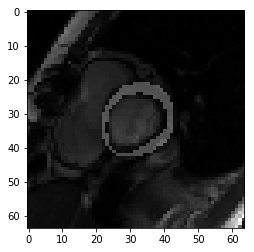

In [3]:
![ -f scd_lvsegs.npz ] || wget https://github.com/Warvito/MRAI_workshop/blob/master/scd_lvsegs.npz

data = np.load('scd_lvsegs.npz')  # load all the data from the archive

images = data['images']  # images in BHW array order
segs = data['segs']  # segmentations in BHW array order
case_indices = data['caseIndices']  # the indices in `images` for each case

images = images.astype(np.float32) / images.max()  # normalize images

plt.imshow(images[13] + segs[13] * 0.25, cmap='gray')  # show image 13 with segmentation

In [5]:
images = images.reshape(images.shape[0], 64, 64, 1)
segs = segs.reshape(segs.shape[0], 64, 64, 1)

In [6]:
segs.shape

(420, 64, 64, 1)

## Split data into training and test

For this exercise, we will divide the data between train and test data, choosing to retain the last 6 cases as our test set. Typically you would want to have a training dataset, a validation dataset checked periodically during training to ensure the network continues to produce good results for data is isn't trained on, and a test dataset used to validate the training after the fact. 

In [19]:
test_index = case_indices[-6, 0]  # keep the last 6 cases for testing

# Divide the images, segmentations, and categories into train/test sets
train_images, train_segs = images[:test_index], segs[:test_index]
test_images, test_segs = images[test_index:], segs[test_index:]

## Define loss function

As loss function, for this exercise we will use the Dice loss, which measure the overlap between the ground truth segmentation and the predicted segmentation.

In [20]:
def dice_coef(y_true, y_pred, smooth=1):
    """ Function to calculate the dice loss with the definition given in [1] using a square in the denominator.

    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
         
    References:
    [1] Milletari, F., Navab, N., & Ahmadi, S. A. (2016). V-net: Fully convolutional neural networks for volumetric
    medical image segmentation. 3DV 2016. https://arxiv.org/pdf/1606.04797v1.pdf
    """
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = y_true * tf.transpose(y_pred)
    union = y_true * tf.transpose(y_true) + y_pred * tf.transpose(y_pred)
    return (2. * intersection + smooth) / (union + smooth)


def dice_coef_loss(y_true, y_pred):
    return tf.reduce_mean(1 - dice_coef(y_true, y_pred), axis=-1)

## Define segmentation network

As neural network, we used a simple auto-encoder, which has a downsampling path with four layers using strided convolutions to reduce dimensions. After the bottom layer the decoding path upsamples using strided transpose convolutions.

However, the current network architecture is doing poorly. Modify the current network to improve the segmentation accuracy. Some of the possible solutions are:

- Add layers
- Add more filters
- Add dropout layers
- Change activation function

In [21]:
# Segmentation network
inputs = keras.Input(shape=(64, 64, 1), name='SegNet')

x = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='linear', use_bias='False')(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.MaxPooling2D()(x)

x = keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='linear', use_bias='False')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Activation(activation='relu')(x)

outputs = keras.layers.Conv2D(filters=1, kernel_size=3, padding='same', activation='sigmoid')(x)

model = keras.Model(inputs=inputs, outputs=outputs)


In [17]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
activation_4 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 32, 32)        128 

## Train network

Once we have defined the network, we need to train it. An strategy is to load the whole dataset into memory at once, but typically this isn't possible due to memory restrictions. A different strategy is to create batches for each train step, which means that in each iteration only few image (batch) would be used for training.

In [22]:
%%time
optimizer = keras.optimizers.Adam(lr=3e-4)
model.compile(loss=dice_coef_loss,
              optimizer=optimizer)

n_epochs = 20
history = model.fit(train_images, train_segs,
                    batch_size=64,
                    epochs=n_epochs)

Train on 368 samples
Epoch 1/20
368/368 [==============================] - 16s 42ms/sample - loss: 0.1346
Epoch 2/20
368/368 [==============================] - 9s 24ms/sample - loss: 0.0978
Epoch 3/20
368/368 [==============================] - 9s 25ms/sample - loss: 0.0781
Epoch 4/20
368/368 [==============================] - 9s 25ms/sample - loss: 0.0641
Epoch 5/20
368/368 [==============================] - 9s 24ms/sample - loss: 0.0518
Epoch 6/20
368/368 [==============================] - 9s 25ms/sample - loss: 0.0416
Epoch 7/20
368/368 [==============================] - 9s 25ms/sample - loss: 0.0334
Epoch 8/20
368/368 [==============================] - 9s 25ms/sample - loss: 0.0265
Epoch 9/20
368/368 [==============================] - 9s 25ms/sample - loss: 0.0210
Epoch 10/20
368/368 [==============================] - 9s 26ms/sample - loss: 0.0168
Epoch 11/20
368/368 [==============================] - 9s 25ms/sample - loss: 0.0137
Epoch 12/20
368/368 [==============================]

In [23]:
sample=(train_images[10])[np.newaxis,:]
pred_sample=model.predict(sample)

In [25]:
pred_sample.max()

0.40657175

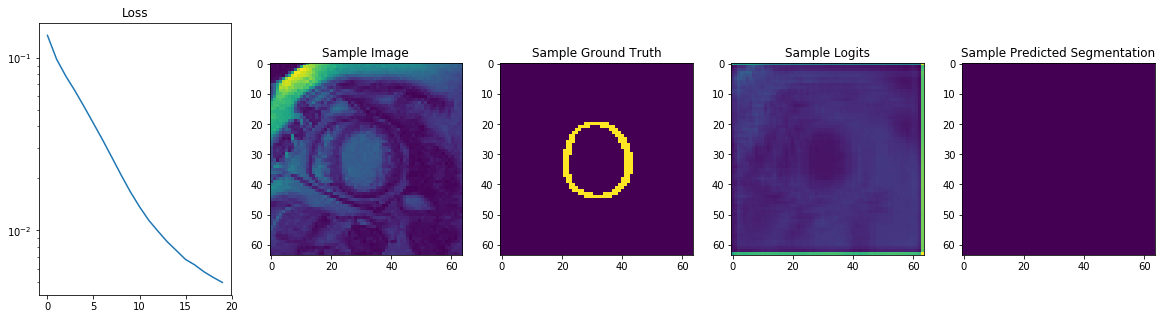

In [24]:
# Sample an image from the training data and look at the segmentation the network predicted for it
fig,ax=plt.subplots(1,5,figsize=(20,5))
ax[0].set_title('Loss')
ax[0].semilogy(history.history['loss'])
ax[1].set_title('Sample Image')
ax[1].imshow(train_images[10,:,:,0])
ax[2].set_title('Sample Ground Truth')
ax[2].imshow(train_segs[10,:,:,0])
ax[3].set_title('Sample Logits')
ax[3].imshow(pred_sample[0,:,:,0])
ax[4].set_title('Sample Predicted Segmentation')
ax[4].imshow(pred_sample[0,:,:,0]>0.5)

## Test
Once the network is been train, we can now apply the test data to the network. These images were never seen by the network so how well the task is performed is an indicator of how generalized and robust the network is:

In [16]:
model.evaluate(test_images, test_segs,
                    batch_size=64)

52/52 [==============================] - 0s 6ms/sample - loss: 0.0473


0.047270480543375015

52/52 [==============================] - 0s 5ms/sample - loss: 0.0473
Test loss: 0.047270480543375015


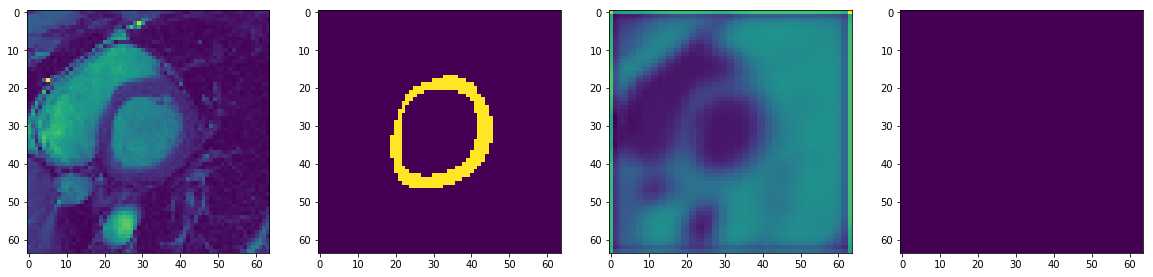

In [17]:
testloss = model.evaluate(test_images, test_segs,
                    batch_size=64)
pred=model.predict(test_images)

seg=pred>0.5

fig,ax=plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(test_images[10,:,:,0])
ax[1].imshow(test_segs[10,:,:,0])
ax[2].imshow(pred[10,:,:,0])
ax[3].imshow(seg[10,:,:,0])

print('Test loss:',testloss)

# 2. Classification using clinical metrics 

In this part of the workshop, we aim to use the segmentations produced from the previous segmentation network to compute the following clinical metrics LVEDV, LVESV, LVSV and LVEF to classify the between healthy and heart failure subjects.

## DNN network

For classification, we will use a deep neural network classifier (DNN) with two layers with sizes 20 and 10. To evaluate the performances of the classifier we will compute accuracy, precision and recall.

In [15]:
def compute_metrics(y_true, yPred, target_names):
    """ Compute metrics
    Parameters
    ----------
    yPred: labels predicted using DNN
    y_true: ground truth labels
    target_names:  names matching the labels
    """

    BACC = balanced_accuracy_score(y_true, yPred)
    PRE = precision_score(y_true, yPred, average=None)
    REC = recall_score(y_true, yPred, average=None)
    print('Balanced accuracy  {0:.2f}'.format(BACC))

    headers = ["precision", "recall"]

    rows = zip(target_names, PRE, REC)

    digits = 2
    longest_last_line_heading = 'weighted avg'
    name_width = max(len(cn) for cn in target_names)
    width = max(name_width, len(longest_last_line_heading), digits)
    head_fmt = u'{:>{width}s} ' + u' {:>9}' * len(headers)
    report = head_fmt.format(u'', *headers, width=width)
    report += u'\n\n'
    row_fmt = u'{:>{width}s} ' + u' {:>9.{digits}f}' + u' {:>9}\n'
    for row in rows:
        report += row_fmt.format(*row, width=width, digits=digits)
    report += u'\n'

    print(report)

    return BACC * 100, PRE * 100, REC * 100
  
# Create a DNN network for classification with two layers with sizes 20 and 10. 
class DNN(torch.nn.Module):
    '''Plain dense neural network of linear layers using dropout and ReLU activation.
    Size of the hidden layers: [20,10]
    numClasses: number of classes used for the classification'''
    def __init__(self, numClasses):
        super().__init__()
        dropout_value = 0.05
        ################
        # TO COMPLETE
        ################
    def forward(self, x):
        ################
        # TO COMPLETE
        ################
        return 


NameError: name 'torch' is not defined

## Download the data
To ensure that everyone work with the same data, download the following file that contains the images segmented with the previous network optimised.

In [ ]:
![ -f data.npz ] || wget https://github.com/estherpuyol/MRAI_workshop/raw/master/data.npz
data_file_name = 'data.npz'

## Compute clinical metricas and save them in a matrix called metrics
- LVEDV (maximum volume of the cardiac cycle)
- LVESV (minimum volume of the cardiac cycle)
- LVSV = LVEDV - LVESV 
- LVEF = LVSV/LVEDV*100 

Then:
- Generate a matrix ```metrics``` that concatenate LVEDV, LVESV, LVSV and LVEF

In [ ]:
# Load data
data = np.load(data_file_name)

# Save fields inside data
images = data['images']  # (805, 128, 128)
segs = data['segs']  # (805, 128, 128)
caseNames = data['caseNames']  # 45
caseIndices = data['caseIndices']  # 45
caseTypeNames = ['Normal', 'Heart Failure']
caseTypes = data['caseTypes']  # 45
caseTypes[caseTypes == 2] = 0
caseVoxelSize = data['caseVoxelSize']
isEDImg = data['isEDImg']  # 805
segTypes = data['segTypes']  # ['Background', 'LV Pool']


# Compute LVEDV, LVESV, LVSV and LVEF
metrics = np.zeros((len(caseNames), 4))
for ii, ind in enumerate(caseIndices):
    indED_pat = isEDImg[ind[0]:ind[1]]
    img_pat = images[ind[0]:ind[1], :, :]
    seg_pat = segs[ind[0]:ind[1], :, :]
    img_ED = img_pat[indED_pat, :, :]
    img_ES = img_pat[~indED_pat, :, :]
    seg_ED = seg_pat[indED_pat, :, :]
    seg_ES = seg_pat[~indED_pat, :, :]
    dx, dy, dz = caseVoxelSize[ii]
    volume_per_voxel = dx * dy * dz * 1e-3
    density = 1.05

    metrics[ii, 0] = np.sum(np.sum(seg_ED == 1, axis=1)) * volume_per_voxel
    metrics[ii, 1] = np.sum(np.sum(seg_ES == 1, axis=1)) * volume_per_voxel
    metrics[ii, 2] = metrics[ii, 0] - metrics[ii, 1]
    metrics[ii, 3] = metrics[ii, 2] / metrics[ii, 0] * 100

## Visualize the data

Plot LVEDV, LVESV, LVSV and LVEF per groups, i.e. LVEDV and LVESV, LVSV and LVEF

In [ ]:
def PlotTwoClassData(X, y, title, _caseTypeNames):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], c='r', label=_caseTypeNames[0])
    plt.scatter(X[y == 1, 0], X[y == 1, 1], c='b', label=_caseTypeNames[1])
    plt.legend()
    plt.title(title)
    

plt.figure(figsize = [14,5])
plt.subplot(121)
PlotTwoClassData(metrics[:,0:2], caseTypes, 'Healthy vs Heart Failure', caseTypeNames)
plt.xlabel('LVEDV')
plt.ylabel('LVESV')
plt.subplot(122)
PlotTwoClassData(metrics[:,2:], caseTypes, 'Healthy vs Heart Failure', caseTypeNames)
plt.xlabel('LVSV')
plt.ylabel('LVEF')


## Split data into training and test

Data is unbalanced (there is no the same number of patients per group). We need to ensure that in the split training/test there is balanced number of classed. To this end use StratifiedShuffleSplit from scikit-learn that will automatically ensure that.
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(metrics, caseTypes):
    X_train, X_test = metrics[train_index, :], metrics[test_index, :]
    y_train, y_test = caseTypes[train_index], caseTypes[test_index]

## Train a DNN network to perform classification


In [ ]:
################
# TO COMPLETE
################

#1. Instance the DNN network
nb_iters = ...
output_size = ...
net = DNN(output_size)

xt = torch.from_numpy(...).type(torch.FloatTensor)
yt = torch.from_numpy(...).type(torch.LongTensor)

# Select the loss fuction for classification
# Docs: https://pytorch.org/docs/stable/nn.html
loss_func = ... 

# Select the Optimizer with lr = 0.0001
# Docs: https://pytorch.org/docs/stable/optim.html
opt = ...

losses = []

for i in range(1, nb_iters + 1):

    out = net(xt)  # input x and predict based on x
    loss = loss_func(out, yt)   

    # clear gradients for next train
    ...
    # backpropagation, compute gradients
    ...
    # apply gradients
    ...
    # Stor the loss over iteration 
    ...

    if i % (nb_iters // 10) == 0:
        print(i, losses[-1])

# Plot total loss over iterations
...


# Deploy network and compute metrics

First deploy the trained netowrk and then compute the following metrics: balanced accuracy, precision, recall


In [ ]:
################
# TO COMPLETE
################
with torch.no_grad():
    net.eval()
    out = torch.from_numpy(...).float()
    # Deploy DNN for the test dataset and compute the predicted label
    out = ... 
    # Convert to numpy array
    out = ... 
    # Select the highest probability for each input 
    y_pred = np.argmax(out, axis = 1)
    # Compute metrics
    ...